In [14]:
import os
import zipfile

#Base de datos
from google.colab import files
files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [2]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs
#!kaggle datasets download -d whats2000/breast-cancer-semantic-segmentation-bcss

Dataset URL: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
License(s): other
100% 201M/202M [00:10<00:00, 24.3MB/s]
100% 202M/202M [00:10<00:00, 20.9MB/s]


In [3]:
local_zip = '/content/cityscapes-image-pairs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [1]:
#import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#base_dir = "/kaggle/input/cityscapes-image-pairs/cityscapes_data"

#train_dir = f"{base_dir}/train"
#val_dir = f"{base_dir}/val"

training_images  = glob("/content/cityscapes_data/train/*")
validation_images  = glob("/content/cityscapes_data/val/*")

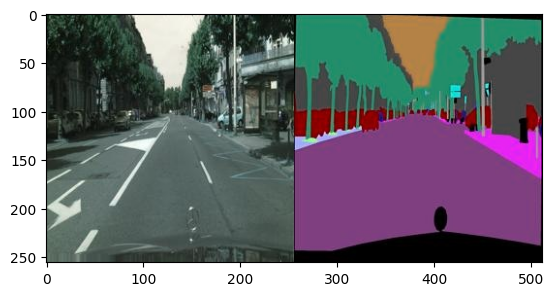

In [2]:
input_image_path = training_images[0]
train_image = cv2.imread(input_image_path)
plt.imshow(train_image)

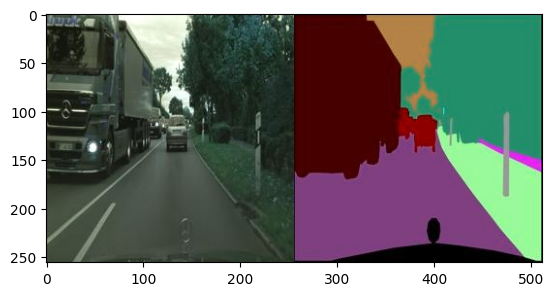

In [3]:
input_image_path = validation_images[0]
val_image = cv2.imread(input_image_path)
plt.imshow(val_image)

In [4]:
print(len(training_images))
print(len(validation_images))

2975
500


In [5]:
#train_image.shape

In [6]:
#train_image[:,:256,:].shape, train_image[:,256:,:].shape

In [7]:
image, mask = train_image[:,:256,:], train_image[:,256:,:]

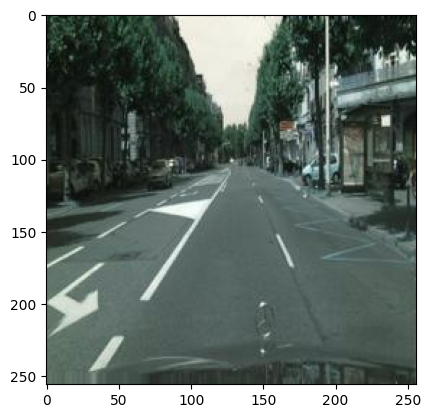

In [8]:
plt.imshow(image)

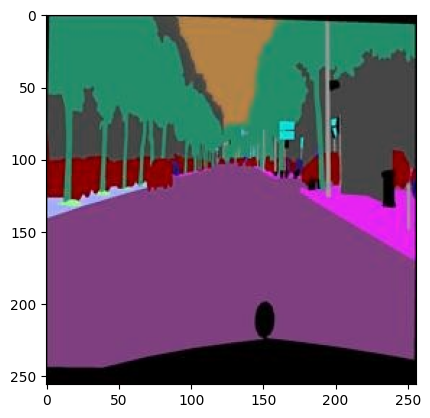

In [9]:
plt.imshow(mask)

In [10]:
#import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor
# import torch.multiprocessing as mp

In [11]:
# mp.set_start_method('spawn', force=True)

class CityscapesDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.image_paths = glob(os.path.join(self.data_dir, split, '*.jpg'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        train_image = cv2.imread(img_path)

        # Separate the concatenated image into the main image and its corresponding label (mask)
        image = train_image[:, :256, :]
        mask = train_image[:, 256:, :]

        # Apply transformations separately to image and mask
        if self.transform:
            image = self.transform['image'](image)
            mask = self.transform['mask'](mask)

        return image, mask, img_path

In [12]:
base_dir = '/content/cityscapes_data'

# Define separate transformation pipelines for image and mask
image_transform = transforms.Compose([
            ToPILImage(),
            Resize((256, 256)),
            ToTensor(),
        ])
mask_transform = transforms.Compose([
            ToPILImage(),
            Resize((256, 256)),
            ToTensor(),
        ])

data_transform = {'image': image_transform, 'mask': mask_transform}

In [15]:
train_dataset = CityscapesDataset(base_dir, split='train', transform=data_transform)
val_dataset = CityscapesDataset(base_dir, split='val', transform=data_transform)

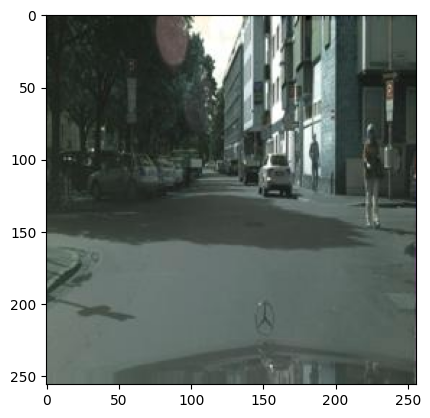

In [16]:
# Example of accessing data
image, mask, image_path = train_dataset[3]
plt.imshow((image.permute(1, 2, 0).numpy()*255).astype(np.uint8))

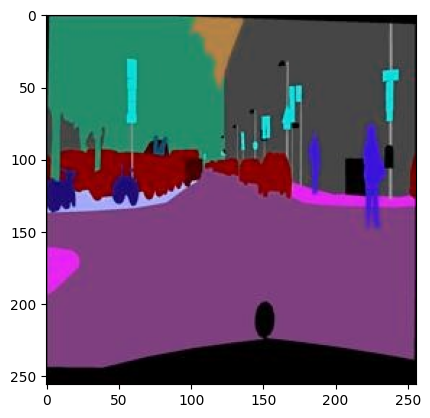

In [17]:
plt.imshow((mask.permute(1, 2, 0).numpy()*255).astype(np.uint8), cmap='gray')
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# **Attention Unet**

**Convolution Block**

Conv -> BatchNorm -> ReLU  
Conv -> BatchNorm -> ReLU  

In [19]:
class ConvBlock(nn.Module):
  def __init__(self, ch_in, ch_out):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1,padding=1, bias=True),
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1,padding=1, bias=True),
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU(inplace=True),
                              )

  def forward(self, x):
    x = self.conv(x)
    return x

**Upsampling Block**

In [20]:
# Upsample -> Conv -> BatchNorm -> ReLU

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,kernel_size=3,stride=1,padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
                                )

    def forward(self, x):
        x = x = self.up(x)
        return x

**Attention Block**

In [21]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias="True"),
                                nn.BatchNorm2d(f_int)
                                )
        self.w_x = nn.Sequential(nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias="True"),
                                nn.BatchNorm2d(f_int)
                                )
        self.psi = nn.Sequential(nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias="True"),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
                                )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return psi*x

**Attention Unet**

In [22]:
class Attention_UNet(nn.Module):
    def __init__(self, n_classes=30, in_channel=3, out_channel=3):
        super().__init__()
        ###  Encoder ##
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)

        ### Decoder ###
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)

        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)

        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)

        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)

        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)

        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)

        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)

        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)

        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)

        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)

        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)

        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)

        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)

        d1 = self.conv_1x1(d2)

        return d1

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
attention_unet = Attention_UNet(n_classes=1).to(device)

In [25]:
# Parameters
batch_size = 8
num_workers = 1

# DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [26]:
#Quick test over small subset of data

from torch.utils.data import Subset
import numpy as np

# Load full dataset
train_dataset_full = train_dataset
val_dataset_full = val_dataset

# Define subset size
subset_size = 100  # Number of samples for quick test

# Generate random indices for the subset
train_indices = np.random.choice(len(train_dataset_full), subset_size, replace=False)
val_indices = np.random.choice(len(val_dataset_full), subset_size, replace=False)

# Create subset
train_subset = Subset(train_dataset_full, train_indices)
val_subset = Subset(val_dataset_full, val_indices)

# Create DataLoader for the subset
train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(train_dataset_full), len(val_dataset_full)

train_loader = train_loader_subset
val_loader = val_loader_subset

In [27]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for images, masks, _ in dataloaders[phase]:
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

    return model

In [28]:
model = Attention_UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [31]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
}

#50 epocas
# train loss = 0.0192
# val loss = 0.0265


#100, 150
num_epochs = 50
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.1115
val Loss: 0.1141
Epoch 1/49
----------
train Loss: 0.0394
val Loss: 0.0491
Epoch 2/49
----------
train Loss: 0.0286
val Loss: 0.0395
Epoch 3/49
----------
train Loss: 0.0260
val Loss: 0.0340
Epoch 4/49
----------
train Loss: 0.0244
val Loss: 0.0270
Epoch 5/49
----------
train Loss: 0.0233
val Loss: 0.0238
Epoch 6/49
----------
train Loss: 0.0228
val Loss: 0.0246
Epoch 7/49
----------
train Loss: 0.0220
val Loss: 0.0230
Epoch 8/49
----------
train Loss: 0.0201
val Loss: 0.0246
Epoch 9/49
----------
train Loss: 0.0196
val Loss: 0.0259
Epoch 10/49
----------
train Loss: 0.0187
val Loss: 0.0246
Epoch 11/49
----------
train Loss: 0.0174
val Loss: 0.0226
Epoch 12/49
----------
train Loss: 0.0177
val Loss: 0.0233
Epoch 13/49
----------
train Loss: 0.0175
val Loss: 0.0224
Epoch 14/49
----------
train Loss: 0.0166
val Loss: 0.0214
Epoch 15/49
----------
train Loss: 0.0157
val Loss: 0.0219
Epoch 16/49
----------
train Loss: 0.0154
val Loss: 0.0218
Epoch 1

In [32]:
torch.save(model.state_dict(), '/content/drive/MyDrive/TEC/Research/Semantic Segmentation/Attention_unet_cityscapes_50.pth')

#torch.save(model.state_dict(), '/content/unet_cityscapes_50.pth')

In [35]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/TEC/Research/Semantic Segmentation/Attention_unet_cityscapes_50.pth'))
#model.load_state_dict(torch.load('/content/unet_cityscapes_50.pth'))#

model.to(device)

model.eval()

# Example: Predict on a validation sample
images, masks, _ = next(iter(val_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)

<ipython-input-35-b9bf32d47294>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/TEC/Research/Semantic Segmentation/

In [36]:
import torch
import numpy as np

In [37]:
def calculate_iou(predicted_mask, target_mask):
    intersection = np.logical_and(predicted_mask, target_mask).sum()
    union = np.logical_or(predicted_mask, target_mask).sum()
    iou = intersection / (union + 1e-10)  # Adding a small epsilon to avoid division by zero
    return iou

In [38]:
def calculate_pixel_accuracy(predicted_mask, target_mask):
    correct_pixels = (predicted_mask == target_mask).sum()
    total_pixels = target_mask.size
    accuracy = correct_pixels / total_pixels
    return accuracy

In [39]:
# Assuming outputs and masks are tensors of shape [batch_size, num_classes, height, width]
# Convert outputs and masks to numpy arrays
outputs_np = outputs.cpu().detach().numpy()  # Detach from computational graph and move to CPU
masks_np = masks.cpu().detach().numpy()

iou_scores = []
pixel_accuracies = []

for i in range(len(outputs_np)):
    predicted_mask = np.argmax(outputs_np[i], axis=0)  # Assuming outputs are logits, take argmax
    target_mask = masks_np[i, 0]  # Assuming masks are binary or integer labels (0 for background)

    # Calculate IoU and pixel accuracy for each sample
    iou = calculate_iou(predicted_mask, target_mask)
    #pixel_acc = calculate_pixel_accuracy(predicted_mask, target_mask)

    iou_scores.append(iou)
    #pixel_accuracies.append(pixel_acc)

# Calculate mean IoU and mean pixel accuracy over the entire validation set
mean_iou = np.mean(iou_scores)
#mean_pixel_acc = np.mean(pixel_accuracies)

print(f"Mean IoU: {mean_iou:.4f}")
#print(f"Mean Pixel Accuracy: {mean_pixel_acc:.4f}")

Mean IoU: 0.7709


In [40]:
# Save a sample output for visual verification
save_image(images, 'sample_input.png')
save_image(outputs, 'sample_output.png')
save_image(masks, 'sample_masks.png')

In [41]:
import matplotlib.pyplot as plt

# Load the saved input and output images
input_img = plt.imread('sample_input.png')
output_img = plt.imread('sample_output.png')

# Create a figure with subplots
fig, axs = plt.subplots(2,1, figsize=(12*2, 6*2))

# Display the input image in the first subplot
axs[0].imshow(input_img)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Input Image')

# Display the output image in the second subplot
axs[1].imshow(output_img)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Output Image')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Cargar el modelo entrenado y seguir haciendo pruebas
#'/content/drive/MyDrive/TEC/Research/Semantic Segmentation/unet_cityscapes.pth'

# **Visualización de Feature maps**

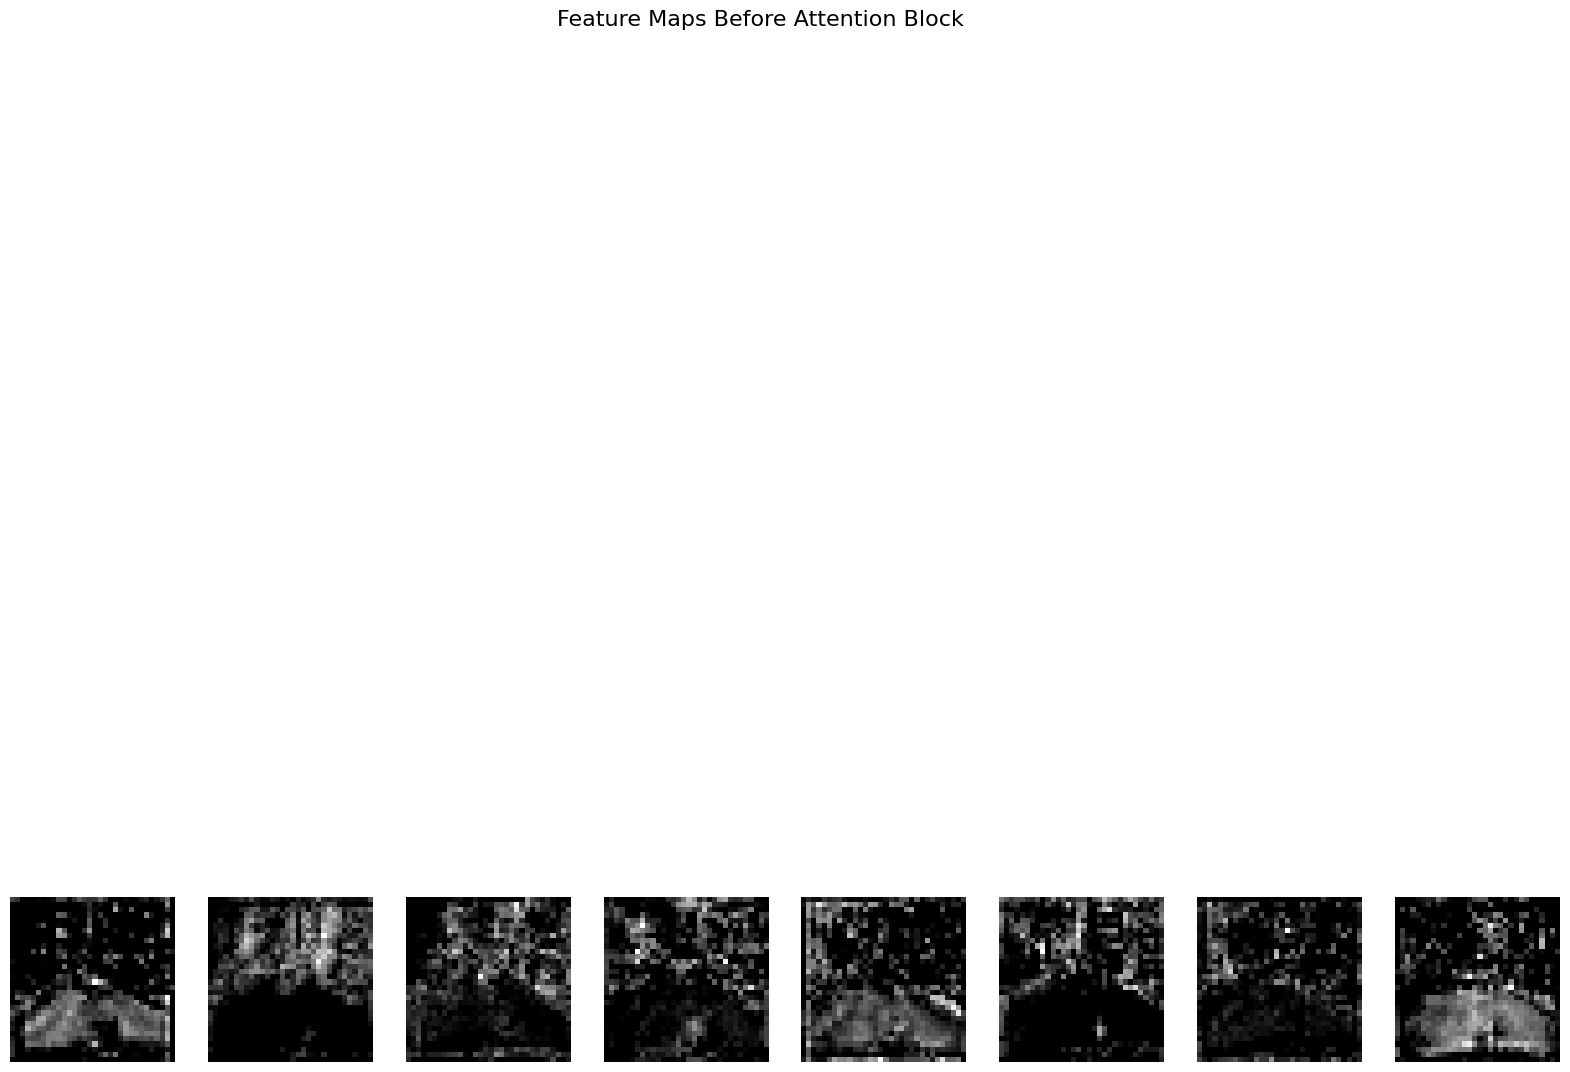

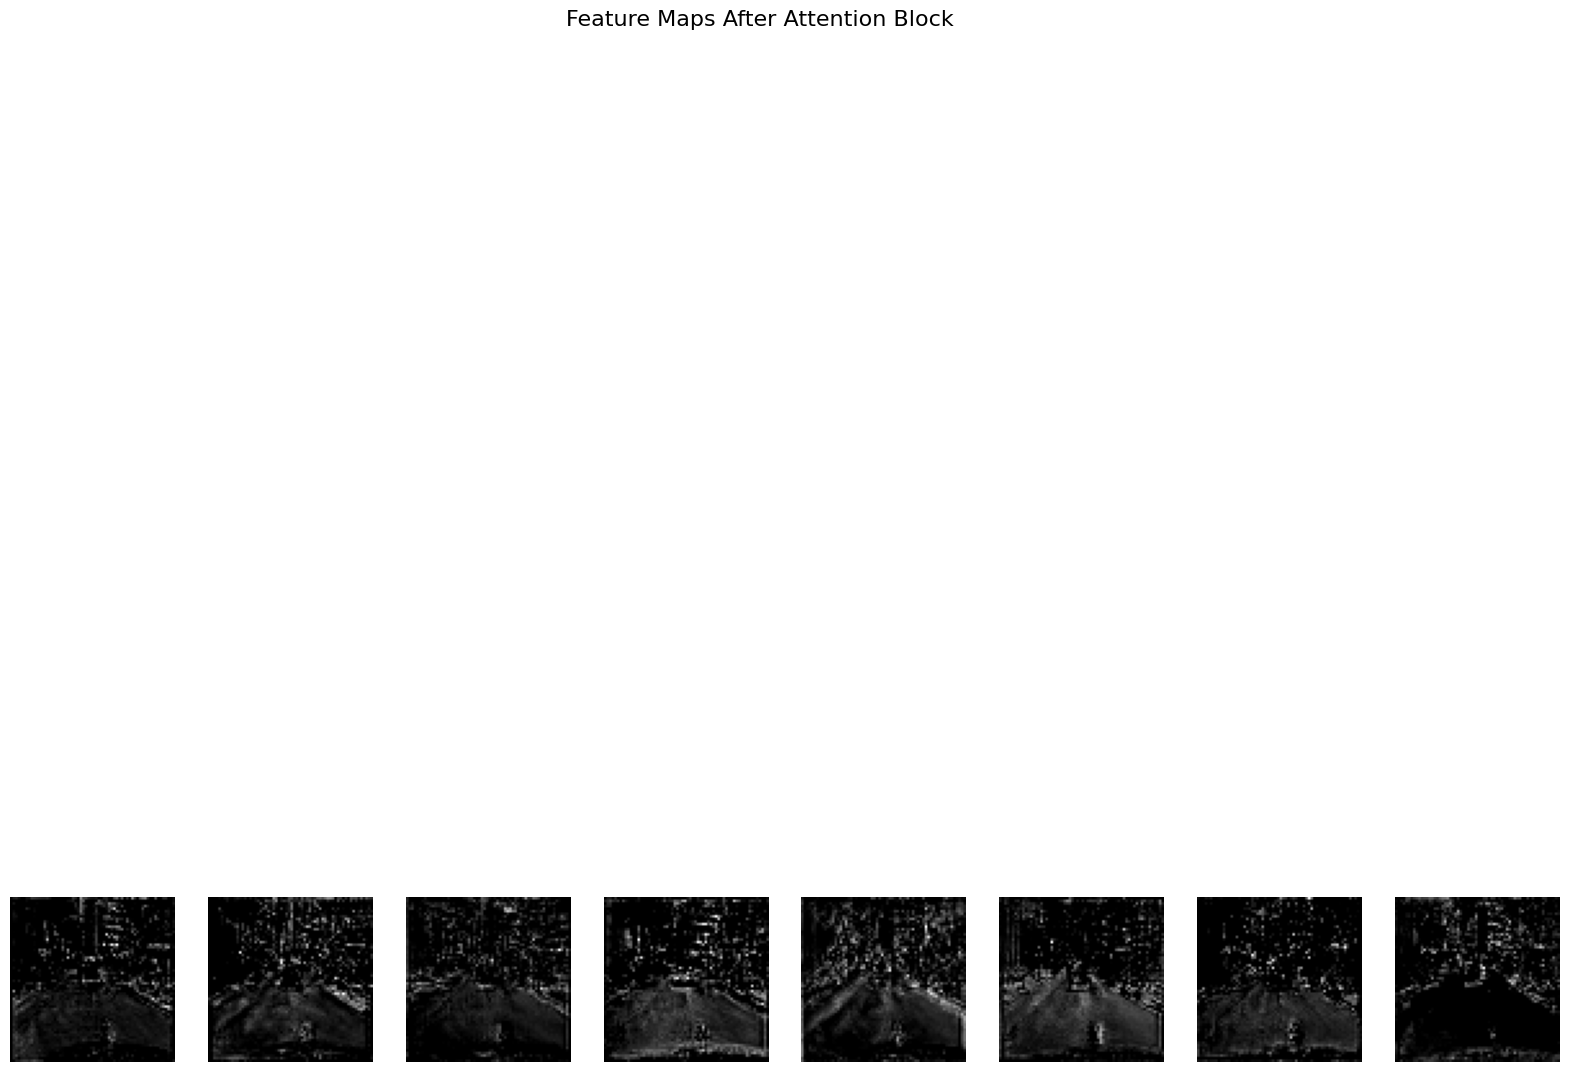

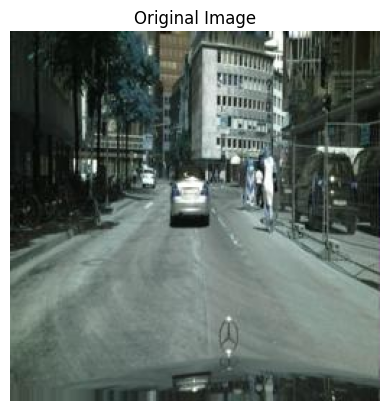

In [46]:
# prompt: Genera un codigo para visualizar el feature map de una imagen antes y despues del attentionblock

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor
import cv2

# Assuming the model, val_loader, and device are already defined and loaded
# If not, please refer to the previous code where these were defined.

# Function to extract feature maps
def get_feature_maps(model, layer_name, input_image, device):
    """
    Extracts feature maps from a specified layer of a model.

    Args:
        model: The trained model.
        layer_name: The name of the layer from which to extract features.
        input_image: The input image tensor.
        device: The device on which to perform the operations ('cuda' or 'cpu').

    Returns:
        The feature maps of the specified layer.
    """
    features = []
    hooks = []
    for name, module in model.named_modules():
      if name == layer_name:
        def hook(module, input, output):
            features.append(output.cpu().detach())
        hooks.append(module.register_forward_hook(hook))

    model.eval()
    with torch.no_grad():
        model(input_image.to(device))
    for h in hooks:
      h.remove()
    return features[0]

# Function to display feature maps
def display_feature_maps(feature_maps, title, num_channels=None):
    """
    Displays a selection of feature maps.

    Args:
        feature_maps: The feature maps tensor.
        title: The title of the plot.
        num_channels: Number of channels to display. If None, all will be displayed
    """

    if num_channels is not None:
      n_channels = min(num_channels, feature_maps.shape[1])
    else:
      n_channels = feature_maps.shape[1]

    fig, axes = plt.subplots(1, n_channels, figsize=(20, 20))
    fig.suptitle(title, fontsize=16)

    if n_channels == 1:
        ax = axes
        ax.imshow(feature_maps[0, 0, :, :], cmap='gray')
        ax.axis('off')
    else:
        for i in range(n_channels):
            ax = axes[i]
            ax.imshow(feature_maps[0, i, :, :], cmap='gray')
            ax.axis('off')
    plt.show()

# Select an image for testing
images, masks, _ = next(iter(val_loader))
image = images[0].unsqueeze(0).to(device)

# Extract feature maps before the attention block (e.g., from the conv4 layer)
feature_maps_before = get_feature_maps(model, "conv4", image, device)

# Extract feature maps after the attention block (e.g., from the att4 layer)
feature_maps_after = get_feature_maps(model, "att4", image, device)

# Display the feature maps
display_feature_maps(feature_maps_before, "Feature Maps Before Attention Block", num_channels=8)
display_feature_maps(feature_maps_after, "Feature Maps After Attention Block", num_channels=8)

# Show the original image
image_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
plt.imshow((image_np * 255).astype(np.uint8))
plt.title("Original Image")
plt.axis('off')
plt.show()


## **Input and output**

In [49]:
# Example: Predict on a validation sample
#images, masks, _ = next(iter(val_loader))
#images = images.to(device)
#with torch.no_grad():
#    outputs = model(images)

np.shape(images[0])

torch.Size([3, 256, 256])

In [50]:
save_image(images[0], 'Entrada.png')
Entrada = plt.imread('Entrada.png')

In [51]:
save_image(outputs[0], 'Salida.png')
Salida = plt.imread('Salida.png')

save_image(masks[0], 'Mascara.png')
Mascara = plt.imread('Mascara.png')

Text(0.5, 1.0, 'Output Image')

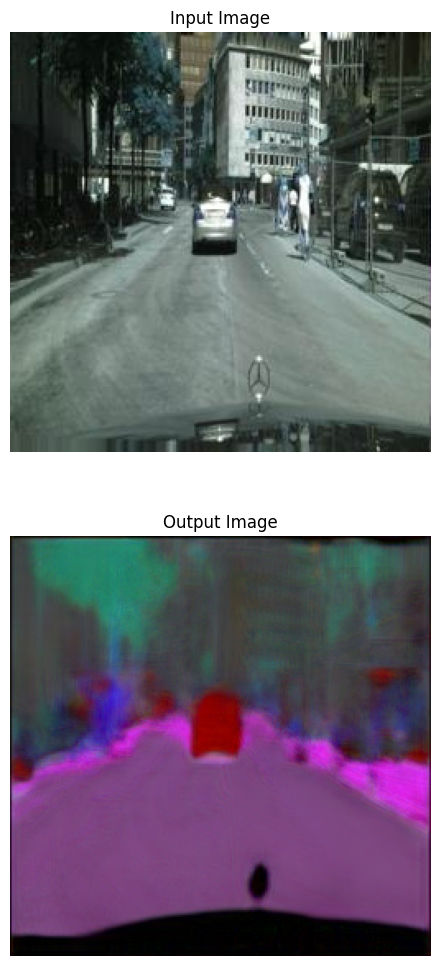

In [52]:
fig, axs = plt.subplots(2,1, figsize=(12*2, 6*2))

axs[0].imshow(Entrada)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Input Image')

# Display the output image in the second subplot
axs[1].imshow(Salida)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Output Image')

## **Taking a kernel from a layer**

In [53]:
#print(model)

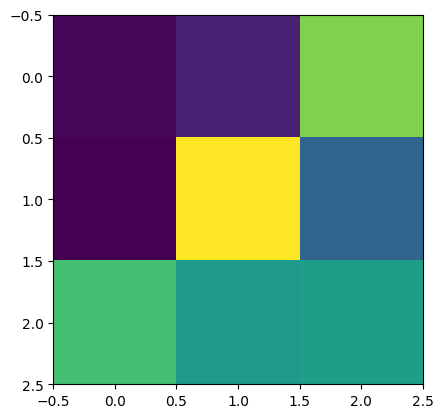

In [54]:
kernel = model.conv1.conv[0].weight[0,0].cpu().data.numpy()
plt.imshow(kernel)

In [55]:
kernel

array([[-0.17803158, -0.1507015 ,  0.1050319 ],
       [-0.1851435 ,  0.17480952, -0.06960358],
       [ 0.06702163,  0.00848975,  0.01613735]], dtype=float32)

In [56]:
from scipy.ndimage.filters import convolve

<ipython-input-56-d51b0ff311b0>:1: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


### **Gray**

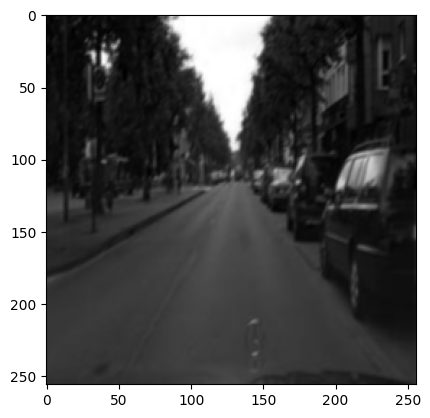

In [78]:
img = images[0].cpu().data.numpy() # Move img to CPU and convert to numpy array
#img = img[0] # Select the first channel of the image (or any other if you want to experiment)

kernels = model.conv1.conv[0].weight[0,0].cpu().data.numpy()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

res = convolve(img[0], kernels) # Convolve the selected channel with the kernel

plt.imshow(res,cmap='gray')
plt.show()

### **RGB**

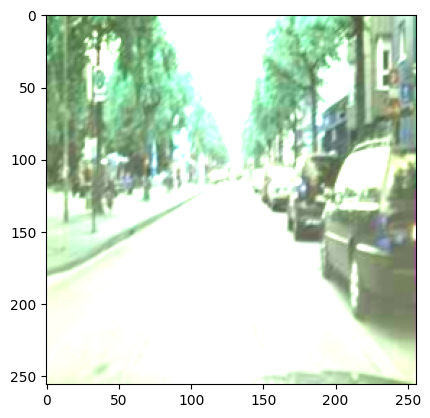

In [80]:
img = images[0].cpu().data.numpy() # Move img to CPU and convert to numpy array

kernels = model.conv1.conv[0].weight[0,0].cpu().data.numpy()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

channels = []
for channel in range(3):
    res = convolve(img[channel,:,:], kernels)
    channels.append(res)

img = np.dstack((channels[0], channels[1], channels[2]))

plt.imshow(img)
plt.show()

## **Kernels Visualizing**

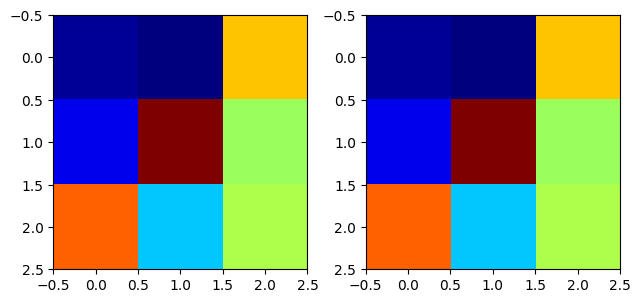

In [85]:
kernels = model.conv1.conv[0].weight.detach().cpu().clone() # Move kernels to CPU
image = kernels[0].cpu().data.numpy() # Move kernels[0] to CPU and convert to numpy

for i in range(1,kernels.shape[0]):
    image = np.dstack((image,kernels[i].cpu().data.numpy())) # Move kernels[i] to CPU and convert to numpy before stacking
img = torch.from_numpy(image).permute(0,2,1)


#First kernel
plt.subplot(1, 2, 1)
plt.imshow(torch.t(kernels[0][0]), cmap='jet')
plt.subplot(1, 2, 2)

#First 3x3 pixels of the image
plt.imshow(img[0][:3,:], cmap='jet')
plt.tight_layout()
plt.show()

In [107]:
def normalization(x):
    x = x - x.min()
    return x /x.max()

def visualize_kernel(x,orientation='v',color='gray',normalize=True):
    '''
    x => Weight of the Convolutional layer
    orientation => h : kernels are horizontally stacked/ v : kernels are vertically stacked
    color => color map of the plot
    normalize => choose if you want to normalize the kernels before plotting
    '''
    if normalize:
        kernels = normalization(x)
    else:
        kernels = x
    image = kernels[0]
    for i in range(1,kernels.shape[0]):
        image = np.dstack((image,kernels[i]))
    img = torch.from_numpy(image).permute(0,2,1)
    if orientation=='v':
        plt.imshow(np.vstack((img[:,:,0],img[:,:,1],img[:,:,2])),cmap=color)
    else:
        plt.imshow(np.hstack((img[:,:,0],img[:,:,1],img[:,:,2])),cmap=color)

def visualize_upkernel(x,orientation='v',color='gray',normalize=True):
    '''
    x => Weight of the Convolutional layer
    orientation => h : kernels are horizontally stacked/ v : kernels are vertically stacked
    color => color map of the plot
    normalize => choose if you want to normalize the kernels before plotting
    '''
    if normalize:
        kernels = normalization(x)
    else:
        kernels = x
    image = kernels[0].cpu().data.numpy() # Move kernels[0] to CPU and convert to numpy array
    for i in range(kernels.shape[0]):
        # Move kernels[i] to CPU and convert to numpy array before stacking
        image = np.hstack((image, kernels[i].cpu().data.numpy()))
    if orientation=='v':
        plt.imshow(np.vstack((image[:,:,0],image[:,:,1])),cmap=color)
    else:
        plt.imshow(np.hstack((image[:,:,0],image[:,:,1])),cmap=color)

## **Downsampling layers**

Text(0.5, 1.0, 'Conv 5')

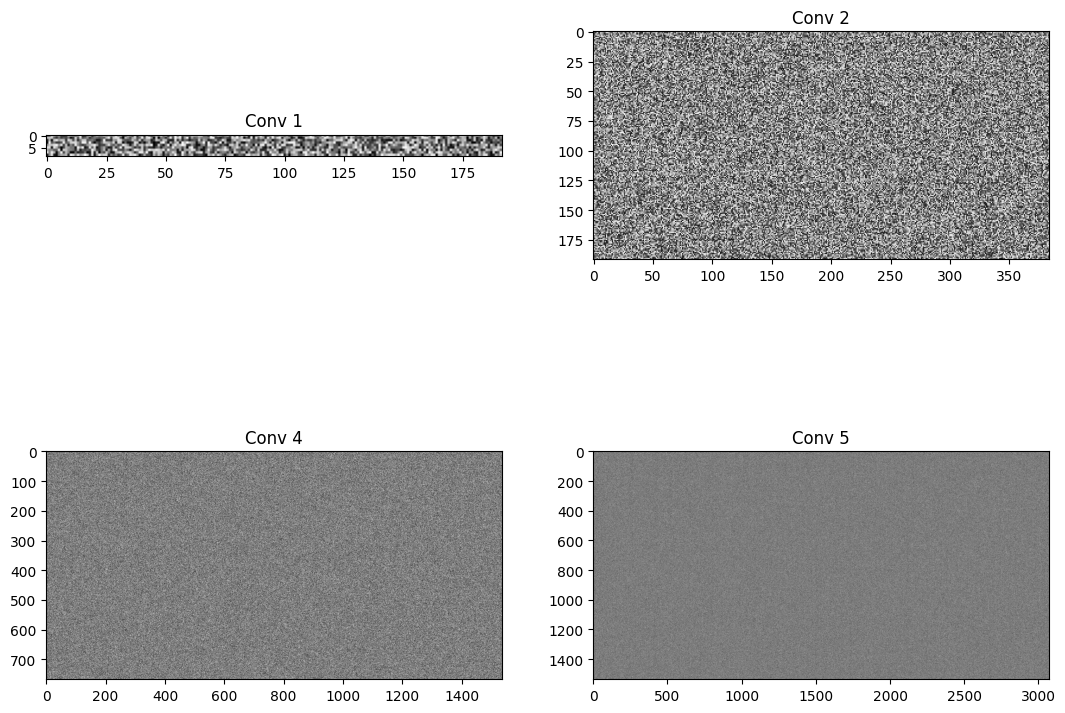

In [94]:
plt.figure(figsize=(20,10), dpi=100)

plt.subplot(2, 3, 1)
visualize_kernel(model.conv1.conv[0].weight.detach().cpu().clone())
plt.title('Conv 1')

plt.subplot(2, 3, 2)
visualize_kernel(model.conv2.conv[0].weight.detach().cpu().clone())
plt.title('Conv 2')

plt.subplot(2, 3, 4)
visualize_kernel(model.conv3.conv[0].weight.detach().cpu().clone())
plt.title('Conv 3')

plt.subplot(2, 3, 4)
visualize_kernel(model.conv4.conv[0].weight.detach().cpu().clone())
plt.title('Conv 4')

plt.subplot(2, 3, 5)
visualize_kernel(model.conv5.conv[0].weight.detach().cpu().clone())
plt.title('Conv 5')

## **Upsampling layers**

Text(0.5, 1.0, 'Up 2')

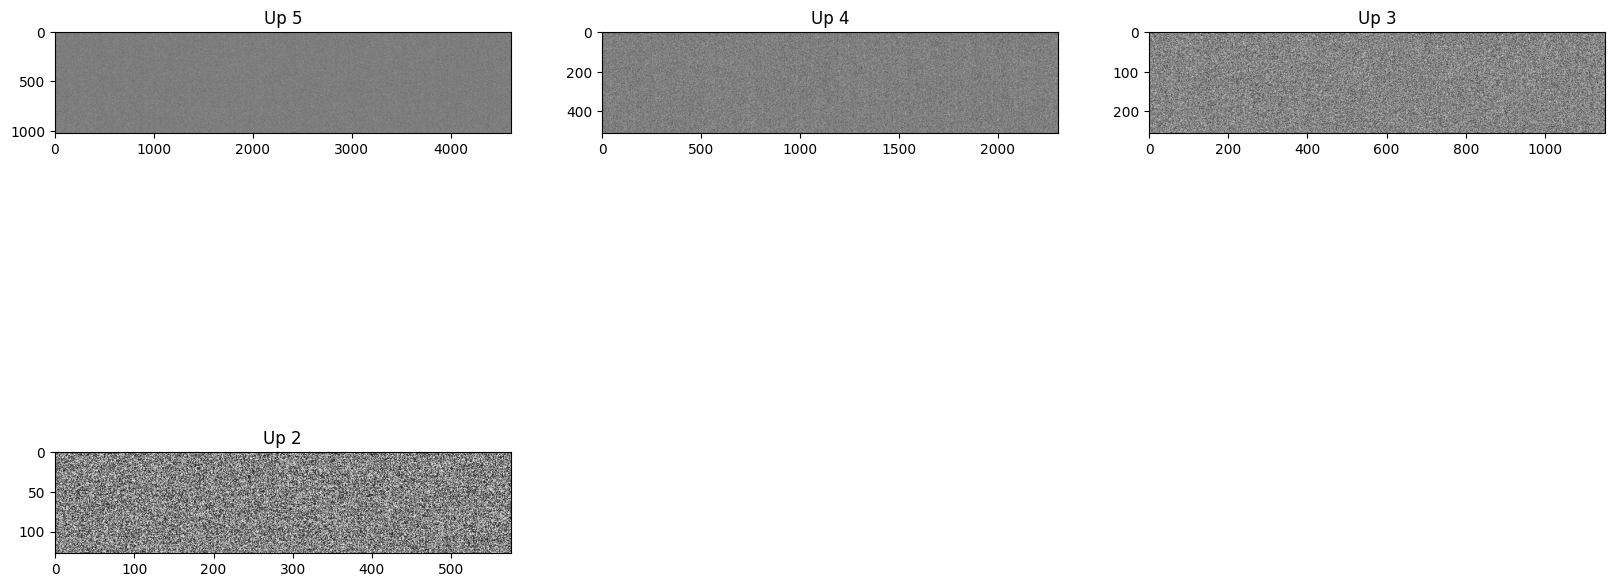

In [101]:
plt.figure(figsize=(20,10), dpi=100)

plt.subplot(2, 3, 1)
# Accessing the convolutional layer within the UpConvBlock
visualize_kernel(model.up5.up[1].weight.detach().cpu().clone(), orientation='h') # Changed from up[0] to up[1]
plt.title('Up 5')

plt.subplot(2, 3, 2)
# Accessing the convolutional layer within the UpConvBlock
visualize_kernel(model.up4.up[1].weight.detach().cpu().clone(), orientation='h') # Changed from up[0] to up[1]
plt.title('Up 4')

plt.subplot(2, 3, 3)
# Accessing the convolutional layer within the UpConvBlock
visualize_kernel(model.up3.up[1].weight.detach().cpu().clone(), orientation='h') # Changed from up[0] to up[1]
plt.title('Up 3')

plt.subplot(2, 3, 4)
# Accessing the convolutional layer within the UpConvBlock
visualize_kernel(model.up2.up[1].weight.detach().cpu().clone(), orientation='h') # Changed from up[0] to up[1]
plt.title('Up 2')



## **Transposed Convolution layer of the Up layers**

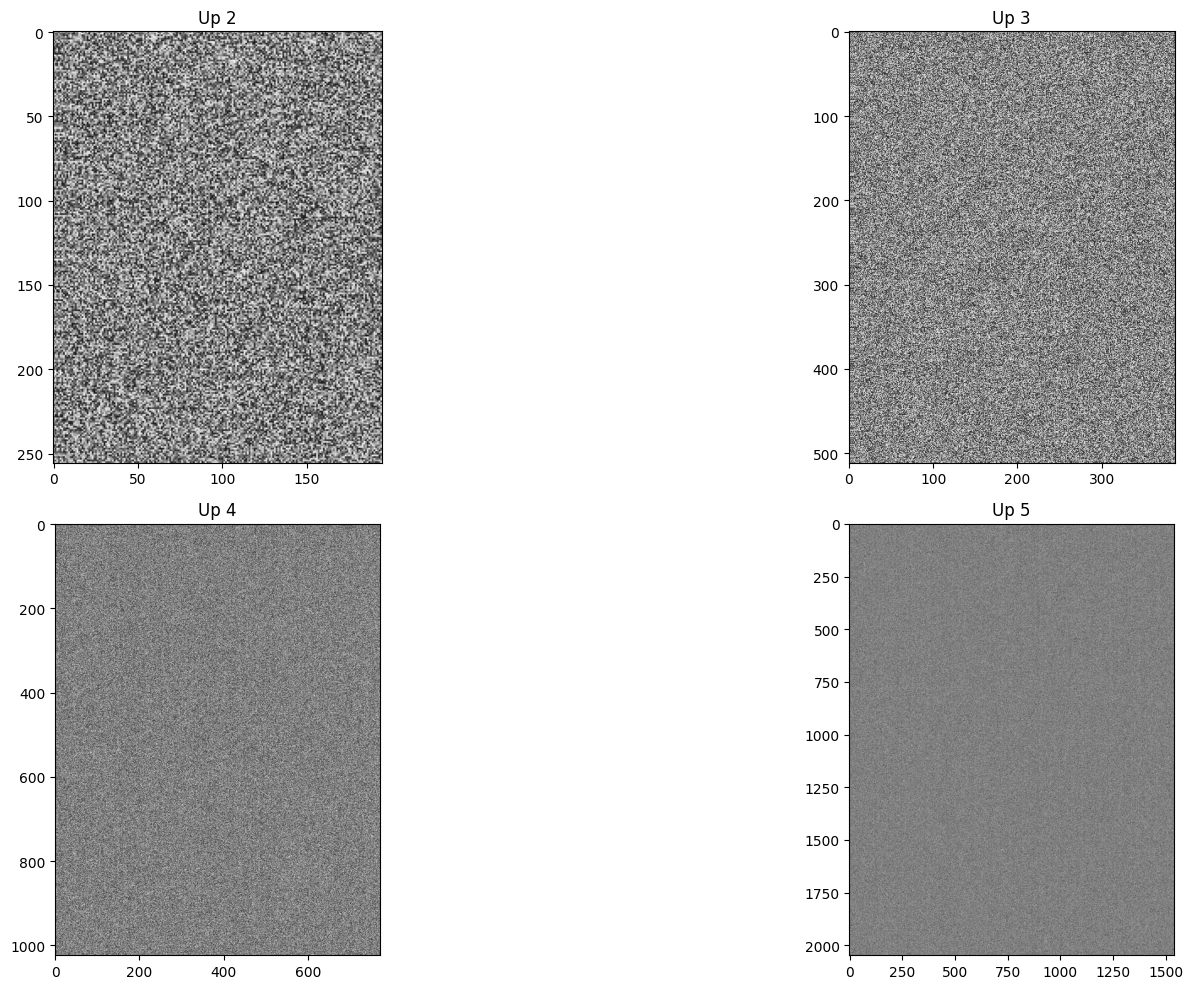

In [110]:
plt.figure(figsize=(20,10), dpi=100)

plt.subplot(2, 2, 1)
# Access the Conv2d layer's weights within the Sequential block
visualize_upkernel(model.up2.up[1].weight.detach().clone())
plt.title('Up 2')

plt.subplot(2, 2, 2)
# Access the Conv2d layer's weights within the Sequential block
visualize_upkernel(model.up3.up[1].weight.detach().clone())
plt.title('Up 3')

plt.subplot(2, 2, 3)
# Access the Conv2d layer's weights within the Sequential block
visualize_upkernel(model.up4.up[1].weight.detach().clone())
plt.title('Up 4')

plt.subplot(2, 2, 4)
# Access the Conv2d layer's weights within the Sequential block
visualize_upkernel(model.up5.up[1].weight.detach().clone())
plt.title('Up 5')

plt.tight_layout()
plt.show()

## **Visualizing Feature Maps**

In [139]:
def get_features(layer, img):
    """
    Retrieves the intermediate features from a specific layer of the model.

    Args:
        layer: The target layer to extract features from.
        img: The input image to the model.

    Returns:
        A list containing the extracted features.
    """

    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    # Register a forward hook to capture the output of the specified layer
    handle = layer.register_forward_hook(hook)

    # Perform a forward pass to trigger the hook and capture the output
    # Convert img (NumPy array) to PyTorch tensor before unsqueeze
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)
    model(img_tensor)  # Pass the image to the model

    # Remove the hook after it's used
    handle.remove()

    return outputs

def show_features(features, max_plots, max_tensor=10, color='jet'):
    """
    Visualizes the extracted features.

    Args:
        features: The list of extracted features.
        max_plots: The maximum number of feature maps to plot.
        max_tensor: The threshold for feature map values to be plotted.
        color: The colormap to use for the plots.
    """

    # Get the number of features in the first element of the 'features' list
    number_of_features = features[0].shape[1]

    # Filter features based on max_tensor value
    output_features = [
        features[0][0][i]
        for i in range(number_of_features)
        if features[0][0][i].max() > max_tensor
    ]

    # Calculate the number of plots per row and column
    total_plot = int(max_plots / 2)

    # Get the total number of filtered features
    total_features = len(output_features)

    # Create subplots and display filtered features
    ct = 1
    for row in range(total_plot):
        for col in range(total_plot):
            if ct - 1 < total_features:
                plt.subplot(total_plot, total_plot, ct)
                plt.axis('off')
                plt.imshow(output_features[ct - 1].cpu().detach().numpy(), cmap='jet')  # Convert to NumPy array for display
                ct += 1
            else:
                break

    plt.show()

In [122]:
def get_features(layer,img):
    outputs= []
    def hook(module, input, output):
        outputs.append(output)
    h = layer.register_forward_hook(hook)
    mask = Salida
   # mask = predict_img(net=net,
   #                            full_img=img,
   #                            scale_factor=1,
   #                            out_threshold=0,
   #                            use_dense_crf=False,
   #                            device=device)
    return outputs

def show_features(features,max_plots,max_tensor=10,color='jet'):
    '''
    features => features from the U-net
    max_plots => Maximum number of plots you want
    max_tensor => If a feature crosses this tensor.max() threshold, then the feature is plotted
    color => colormap of the plot
    '''
    number_of_features = features[0].shape[1]
    output_features=[]
    for i in range(number_of_features):
        if features[0][0][i].max()>max_tensor:
            output_features.append(features[0][0][i])

    total_plot = int(max_plots/2)
    total_features = len(output_features)

    ct=1

    for row in range(total_plot):
        for col in range(total_plot):
            if ct-1<total_features:
                plt.subplot(total_plot,total_plot,ct)
                plt.axis('off')
                plt.imshow(output_features[ct-1],cmap='jet')
                ct+=1
            else:
                break

    plt.show()

In [140]:
#features = get_features(model.conv4.maxpool_conv[1].double_conv, Entrada)
features = get_features(model.conv4.conv[1], Entrada) # Access the second layer within the 'conv' attribute

In [141]:
plt.figure(figsize=(5,5), dpi=100)

show_features(features,1)

<Figure size 500x500 with 0 Axes>